In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

2024-01-04 02:44:40.505519: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 02:44:40.505560: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 02:44:40.505579: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 02:44:40.512956: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


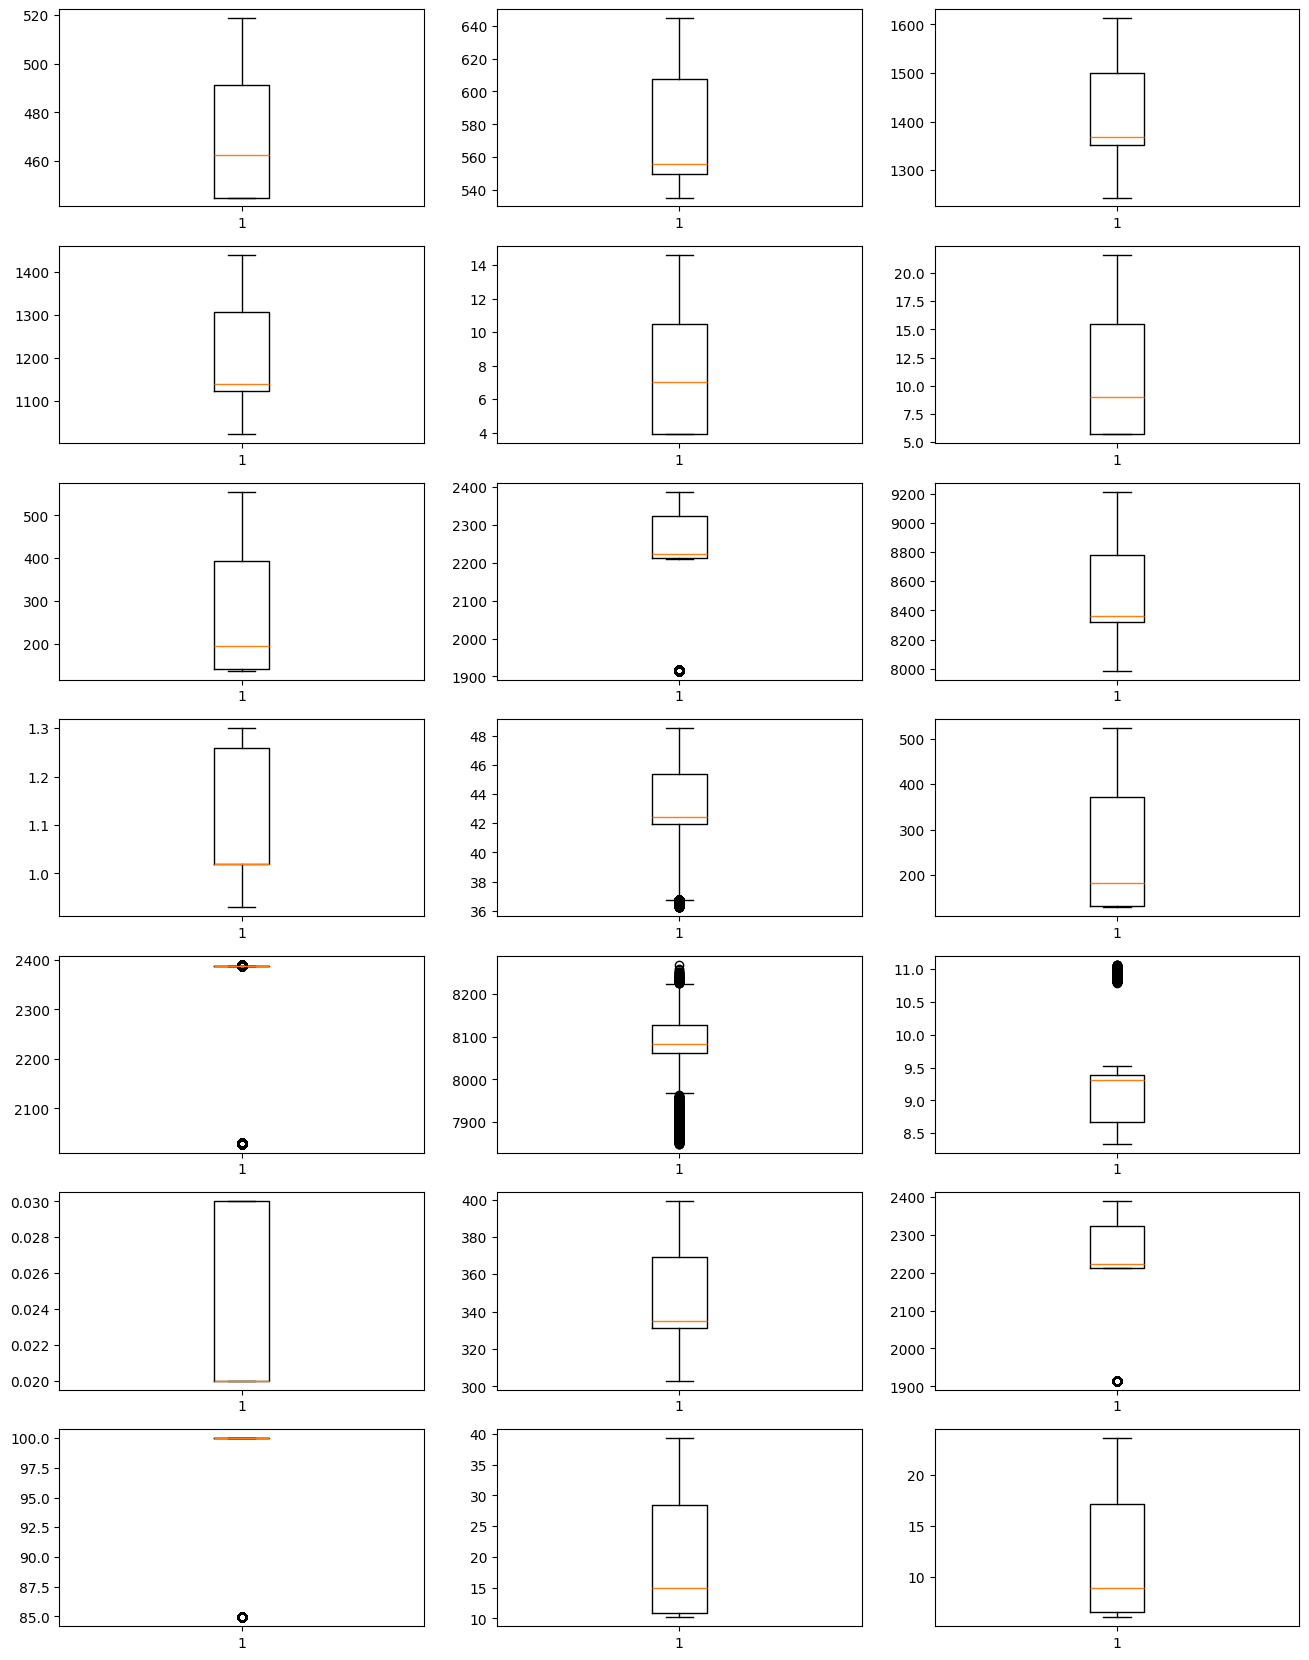

In [2]:
train_data = pd.read_csv("../../CMAPSS/train_FD002.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

In [3]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [4]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [5]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [6]:
test_data = pd.read_csv("../../CMAPSS/test_FD002.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("../../CMAPSS/RUL_FD002.txt", sep = '\s+', header = None)

window_length = 20
shift = 1
early_rul = 125            
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (48819, 20, 21)
Processed training ruls shape:  (48819,)
Processed test data shape:  (1289, 20, 21)
True RUL shape:  (259,)


In [7]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

In [8]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 38)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (39055, 20, 21)
Processed validation data shape:  (9764, 20, 21)
Processed train targets shape:  (39055,)
Processed validation targets shape:  (9764,)


In [9]:
def custom_loss(y_true, y_pred):
    alpha = 0.2
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

In [10]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
def create_CNN_small(): 
    cnn_small = Sequential(
        [
            layers.Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(20, 21)),
            layers.Conv1D(filters=32, kernel_size=6, activation='relu'),
            layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
            layers.MaxPooling1D(pool_size=2),
            layers.Flatten(), 
            layers.Dense(units=32, activation='relu'),
            layers.Dense(units=1, activation='linear')
        ]
    )

    cnn_small.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=custom_loss)
    return cnn_small

cnn_small = create_CNN_small()

2024-01-04 02:44:46.250496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-04 02:44:46.254248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-04 02:44:46.254293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-04 02:44:46.255692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-04 02:44:46.255744: I tensorflow/compile

In [11]:
def scheduler(epoch):
    if epoch < 15:
        return 0.001
    else:
        return 0.0001

callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [12]:
EPOCHS = 50 #150 per la large
BATCH_SIZE = 128 #512 per la large


history = cnn_small.fit(processed_train_data, 
                             processed_train_targets, 
                        epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets), 
                     callbacks = callback, 
                     batch_size=BATCH_SIZE)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50


2024-01-04 02:44:47.775290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-04 02:44:48.268553: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-04 02:44:48.431820: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-04 02:44:49.324802: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7b0039ef40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-04 02:44:49.324832: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-04 02:44:49.329924: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-04 02:44:49.402508: I ./tensorflow/compiler/jit/device_comp

306/306 [==============================] - 6s 8ms/step - loss: 0.0449 - val_loss: 0.0311 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
306/306 [==============================] - 2s 7ms/step - loss: 0.0248 - val_loss: 0.0223 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/50
306/306 [==============================] - 2s 7ms/step - loss: 0.0223 - val_loss: 0.0237 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/50
306/306 [==============================] - 2s 7ms/step - loss: 0.0209 - val_loss: 0.0243 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/50
306/306 [==============================] - 2s 7ms/step - loss: 0.0189 - val_loss: 0.0211 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/50
306/306 [==============================] - 2s 7ms/step - loss: 0.0177 - val_loss: 0.0209 - lr: 0.0010

Epoch 7: Lea

In [14]:
rul_pred_scaled = cnn_small.predict(processed_test_data).reshape(-1)
rul_pred = target_scaler.inverse_transform(rul_pred_scaled.reshape(-1, 1)).reshape(-1)

preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

41/41 [==============================] - 0s 4ms/step
RMSE:  33.03660625065457


In [15]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  33.45277925855442


In [16]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [17]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  22775.01402361715


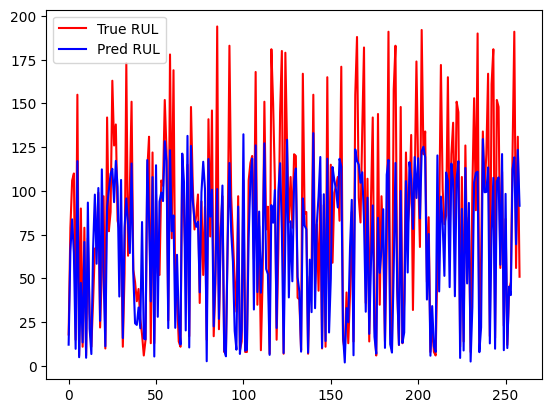

In [18]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

RIPROVARE CON IL TUNING 

In [21]:
def create_CNN_large(): 
    cnn_small = Sequential(
        [
            layers.Conv1D(filters=128, kernel_size=8, activation='relu', input_shape=(20, 21)),
            layers.Conv1D(filters=64, kernel_size=6, activation='relu'),
            layers.Conv1D(filters=32, kernel_size=4, activation='relu'),
            layers.Conv1D(filters=16, kernel_size=2, activation='relu'),
            layers.MaxPooling1D(pool_size=2),
            layers.Flatten(), 
            layers.Dense(units=32, activation='relu'),
            layers.Dense(units=1, activation='linear')
        ]
    )

    cnn_small.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=custom_loss)
    return cnn_small

cnn_large = create_CNN_large()
cnn_large.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 13, 128)           21632     
                                                                 
 conv1d_8 (Conv1D)           (None, 8, 64)             49216     
                                                                 
 conv1d_9 (Conv1D)           (None, 5, 32)             8224      
                                                                 
 conv1d_10 (Conv1D)          (None, 4, 16)             1040      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 2, 16)             0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                      

In [22]:
EPOCHS = 50 #150 per la large
BATCH_SIZE = 128 #512 per la large


history = cnn_large.fit(processed_train_data, 
                             processed_train_targets, 
                        epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets), 
                     callbacks = callback, 
                     batch_size=BATCH_SIZE)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
306/306 [==============================] - 5s 9ms/step - loss: 0.0386 - val_loss: 0.0235 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
306/306 [==============================] - 2s 7ms/step - loss: 0.0241 - val_loss: 0.0232 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/50
306/306 [==============================] - 2s 7ms/step - loss: 0.0218 - val_loss: 0.0232 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/50
306/306 [==============================] - 2s 7ms/step - loss: 0.0200 - val_loss: 0.0184 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/50
306/306 [==============================] - 2s 8ms/step - loss: 0.0183 - val_loss: 0.0179 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/50
306/306 [==============================]

In [23]:
rul_pred_scaled = cnn_large.predict(processed_test_data).reshape(-1)
rul_pred = target_scaler.inverse_transform(rul_pred_scaled.reshape(-1, 1)).reshape(-1)

preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

41/41 [==============================] - 0s 4ms/step
RMSE:  31.862833319629562


In [24]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  32.21619734444047


In [25]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  25606.4071758922


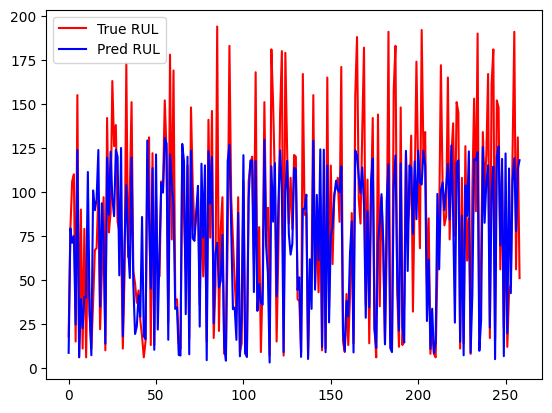

In [26]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

Buone potenzialità !!!!

Provare anche con le LSTM in questo notebook